In [1]:
import numpy as np
import pandas as pd
# import osmnx as ox
import datetime
import sklearn
import matplotlib.pyplot as plt
import geopy
import json
import ast
import utility
import math
import geopy.distance as gd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow



In [2]:
# !pip install geopy
# !pip install networkx

In [2]:
data = pd.read_csv('orders_autumn_2020.csv')

In [3]:
data

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0
2,2020-08-01 06:54:00.000,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0
3,2020-08-01 07:09:00.000,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0
4,2020-08-01 07:10:00.000,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18701,2020-09-30 19:27:00.000,-1,1,60.170,24.946,60.170,24.945,24,23,0.0,12.8,2.34419,0.0
18702,2020-09-30 19:36:00.000,-8,6,60.185,24.944,60.178,24.949,23,15,0.0,12.8,2.34419,0.0
18703,2020-09-30 19:39:00.000,-14,3,60.186,24.949,60.188,24.956,25,11,0.0,12.8,2.34419,0.0
18704,2020-09-30 19:42:00.000,-11,3,60.172,24.929,60.168,24.930,21,10,0.0,12.8,2.34419,0.0


## Exploration: Basic Data Analysis

In [4]:
print("No. of data points",len(data))

No. of data points 18706


In [5]:
data.isna().sum()

TIMESTAMP                                                 0
ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES      0
ITEM_COUNT                                                0
USER_LAT                                                  0
USER_LONG                                                 0
VENUE_LAT                                                 0
VENUE_LONG                                                0
ESTIMATED_DELIVERY_MINUTES                                0
ACTUAL_DELIVERY_MINUTES                                   0
CLOUD_COVERAGE                                          277
TEMPERATURE                                             277
WIND_SPEED                                              277
PRECIPITATION                                             0
dtype: int64

In [6]:
data.describe()

,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
count,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18429.000000,18429.000000,18429.000000,18706.000000
mean,-1.201058,2.688228,60.175234,24.941244,60.175643,24.941214,33.809313,32.608254,11.996853,16.973536,3.790991,0.332756
std,8.979834,1.886455,0.012674,0.016540,0.011509,0.014482,7.340283,10.018879,23.812605,3.411900,1.456017,1.129234
min,-41.000000,1.000000,60.153000,24.909000,60.149000,24.878000,10.000000,6.000000,0.000000,6.100000,0.077419,0.000000
25%,-7.000000,1.000000,60.163000,24.926000,60.167000,24.930000,28.000000,25.000000,0.000000,14.400000,2.696190,0.000000
50%,-2.000000,2.000000,60.175000,24.943000,60.170000,24.941000,33.000000,32.000000,0.000000,16.700000,3.631970,0.000000
75%,5.000000,4.000000,60.186000,24.954000,60.186000,24.950000,38.000000,40.000000,25.000000,18.900000,4.692530,0.000000
max,34.000000,11.000000,60.201000,24.980000,60.219000,25.042000,82.000000,58.000000,100.000000,26.700000,9.857300,6.315790


In [7]:
print("Starting date from data: ", min(data["TIMESTAMP"]))
print("Ending date from data: ", max(data["TIMESTAMP"]))

Starting date from data:  2020-08-01 06:07:00.000
Ending date from data:  2020-09-30 20:04:00.000


In [8]:
data.iloc[200,:]

TIMESTAMP                                               2020-08-01 15:58:00.000
ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES                        -15
ITEM_COUNT                                                                    1
USER_LAT                                                                 60.158
USER_LONG                                                                24.952
VENUE_LAT                                                                 60.16
VENUE_LONG                                                               24.941
ESTIMATED_DELIVERY_MINUTES                                                   38
ACTUAL_DELIVERY_MINUTES                                                      23
CLOUD_COVERAGE                                                              0.0
TEMPERATURE                                                                19.4
WIND_SPEED                                                             0.750587
PRECIPITATION                           

In [9]:
data["time"] = pd.to_datetime(data["TIMESTAMP"])

In [10]:
data["time"]

0       2020-08-01 06:07:00
1       2020-08-01 06:17:00
2       2020-08-01 06:54:00
3       2020-08-01 07:09:00
4       2020-08-01 07:10:00
                ...        
18701   2020-09-30 19:27:00
18702   2020-09-30 19:36:00
18703   2020-09-30 19:39:00
18704   2020-09-30 19:42:00
18705   2020-09-30 20:04:00
Name: time, Length: 18706, dtype: datetime64[ns]

In [11]:
data

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,time
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,2020-08-01 06:07:00
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,2020-08-01 06:17:00
2,2020-08-01 06:54:00.000,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0,2020-08-01 06:54:00
3,2020-08-01 07:09:00.000,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0,2020-08-01 07:09:00
4,2020-08-01 07:10:00.000,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0,2020-08-01 07:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18701,2020-09-30 19:27:00.000,-1,1,60.170,24.946,60.170,24.945,24,23,0.0,12.8,2.34419,0.0,2020-09-30 19:27:00
18702,2020-09-30 19:36:00.000,-8,6,60.185,24.944,60.178,24.949,23,15,0.0,12.8,2.34419,0.0,2020-09-30 19:36:00
18703,2020-09-30 19:39:00.000,-14,3,60.186,24.949,60.188,24.956,25,11,0.0,12.8,2.34419,0.0,2020-09-30 19:39:00
18704,2020-09-30 19:42:00.000,-11,3,60.172,24.929,60.168,24.930,21,10,0.0,12.8,2.34419,0.0,2020-09-30 19:42:00


In [12]:
data["date"]= data["time"].dt.date
data["hour"] = data["time"].dt.hour
data["weekday"] = data["time"].dt.weekday

In [13]:
data.loc[data["date"]==datetime.date(2020, 8, 1)]

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,time,date,hour,weekday
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,2020-08-01 06:07:00,2020-08-01,6,5
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,2020-08-01 06:17:00,2020-08-01,6,5
2,2020-08-01 06:54:00.000,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0,2020-08-01 06:54:00,2020-08-01,6,5
3,2020-08-01 07:09:00.000,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0,2020-08-01 07:09:00,2020-08-01,7,5
4,2020-08-01 07:10:00.000,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0,2020-08-01 07:10:00,2020-08-01,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2020-08-01 20:00:00.000,-16,1,60.165,24.937,60.167,24.940,30,14,0.0,16.7,2.10514,0.0,2020-08-01 20:00:00,2020-08-01,20,5
295,2020-08-01 20:23:00.000,-2,4,60.194,24.941,60.194,24.956,27,25,0.0,16.7,2.10514,0.0,2020-08-01 20:23:00,2020-08-01,20,5
296,2020-08-01 20:47:00.000,3,1,60.183,24.961,60.187,24.961,26,29,0.0,16.7,2.10514,0.0,2020-08-01 20:47:00,2020-08-01,20,5
297,2020-08-01 21:22:00.000,-13,4,60.178,24.927,60.167,24.940,34,21,0.0,16.7,2.32975,0.0,2020-08-01 21:22:00,2020-08-01,21,5


## Data Analysis by grouping

In [14]:
## How many orders are we getting each hour for date -> 2020-08-01
data.loc[data["date"]==datetime.date(2020, 8, 1)].groupby("hour").count()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,time,date,weekday
hour,,,,,,,,,,,,,,,,
6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
8,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
9,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
10,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
11,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
12,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
13,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
14,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23


In [15]:
## How many orders are we getting each hour for date -> 2020-08-02
data.loc[data["date"]==datetime.date(2020, 8, 2)].groupby("hour").count()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,time,date,weekday
hour,,,,,,,,,,,,,,,,
6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
7,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
8,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
9,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
10,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
11,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
12,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
13,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
14,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39


In [16]:
## Total no. of orders by hours and how many items orders were ordered
no_orders_hourly = data.groupby("hour").count()["TIMESTAMP"]
item_count_hourly = data.groupby("hour").sum()["ITEM_COUNT"]

no_orders_hourly

hour
4        3
5       78
6      198
7      610
8     1521
9     1593
10    1487
11    1337
12    1292
13    1580
14    1946
15    2125
16    1912
17    1525
18     918
19     419
20      85
21      72
22       5
Name: TIMESTAMP, dtype: int64

### Hourly Analysis

[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21  5 22  4]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


Text(0.5, 1.0, 'Orders crowd for each hour')

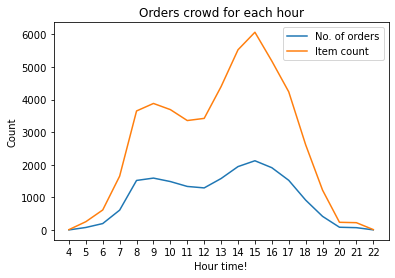

In [17]:
print(data.hour.unique())
hour_idx = [i for i, _ in enumerate(data.hour.unique())]

print(hour_idx)
plt.plot(hour_idx, no_orders_hourly)
plt.plot(hour_idx, item_count_hourly)
plt.legend(["No. of orders", "Item count"])
## order from 4th hour of day starts and end at 22nd, thats why from 4 to 22.
plt.xticks(hour_idx, ["4","5", "6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22"])
plt.xlabel("Hour time!")
plt.ylabel("Count")
plt.title("Orders crowd for each hour")

### Weekday Analysis

In [18]:
weekdata_group = data.groupby("weekday").count()
# weekdata_group["TIMESTAMP"]

[5 6 0 1 2 3 4]


Text(0, 0.5, 'No. of orders')

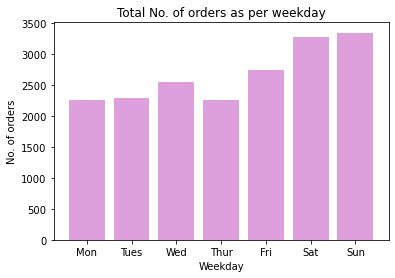

In [19]:
print(data.weekday.unique())

weekday_idx = [i for i, _ in enumerate(data.weekday.unique())]

plt.bar(weekday_idx, weekdata_group["TIMESTAMP"].values, color='plum')
plt.xticks(weekday_idx, ["Mon", "Tues", "Wed", "Thur", "Fri", "Sat", "Sun"])
plt.title("Total No. of orders as per weekday")
plt.xlabel("Weekday")
plt.ylabel("No. of orders")

### Delivery Time Analysis

In [20]:
print("No. of deliveries for which time gets exceeded from estimated delivery time: ", len(data[data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"] >0]))
print("No. of deliveries for which before estimated time: ", len(data[data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"] <0]))

No. of deliveries for which time gets exceeded from estimated delivery time:  7662
No. of deliveries for which before estimated time:  10255


[7662, 10255]


([<matplotlib.patches.Wedge at 0x124ed902860>,
 [Text(0.24791490578718373, 1.0716987447452442, 'LATE'),
  Text(-0.24791480544750455, -1.071698767956708, 'BEFORE-TIME')],
 [Text(0.13522631224755474, 0.584562951679224, '43%'),
  Text(-0.13522625751682066, -0.5845629643400225, '57%')])

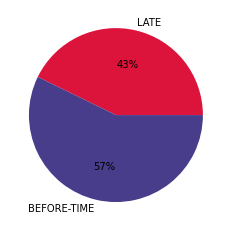

In [21]:
sizes = [len(data[data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"] >0]), len(data[data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"] <0])]
labels = ["LATE", "BEFORE-TIME"]
print(sizes)
plt.pie(sizes, labels=labels, colors = ['crimson','darkslateblue'], autopct='%1.0f%%')

Text(0.5, 1.0, 'Delay time distribution')

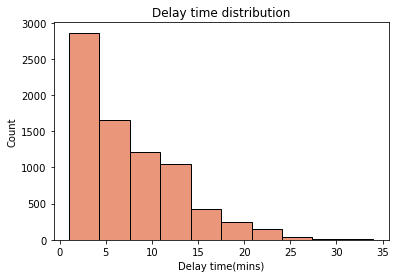

In [22]:
plt.hist(data[data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"] >0]["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"], color="darksalmon", edgecolor='black')
plt.ylabel("Count")
plt.xlabel("Delay time(mins)")
plt.title("Delay time distribution")

# data[data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"] <0]

In [23]:
print("Maximum delay happened in delivery(minutes)", max(data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"]))
print("Minimum delay happened in delivery(minutes)", min(data[data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"]>0]["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"]))


Maximum delay happened in delivery(minutes) 34
Minimum delay happened in delivery(minutes) 1


In [24]:
data.groupby(pd.cut(data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"], [0,10,20,30,40])).count()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,time,date,hour,weekday
ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,,,,,,,,,,,,,,,,,
"(0, 10]",5738,5738,5738,5738,5738,5738,5738,5738,5738,5656,5656,5656,5738,5738,5738,5738,5738
"(10, 20]",1719,1719,1719,1719,1719,1719,1719,1719,1719,1689,1689,1689,1719,1719,1719,1719,1719
"(20, 30]",200,200,200,200,200,200,200,200,200,196,196,196,200,200,200,200,200
"(30, 40]",5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [25]:
# delayed_data = data[data["ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES"]>0]

### Route Analysis

In [26]:
# G = ox.graph_from_bbox(60.164, 60.168, 24.925, 24.935, network_type='drive')
# G_projected = ox.project_graph(G)
# ox.plot_graph(G_projected)

# import geopy.distance

# coords_1 = (60.164, 24.925)
# coords_2 = (60.168, 24.935 )

# print( geopy.distance(coords_1, coords_2).km)
# coords_1 = (60.174, 24.923)
# coords_2 = (60.181, 24.926 )
# # 60.174	24.923	60.181	24.926
# distance_geopy = geopy.distance.distance(coords_1, coords_2).km
# print('distance using geopy: ', distance_geopy)

In [27]:
def calculate_dist_user_venue(coord1, coord2):
    distance_geopy = gd.distance(coord1, coord2).km
    return distance_geopy
    # ('distance using geopy: ', distance_geopy)

In [28]:
data["dist_user_venue"] = data.apply(lambda x: calculate_dist_user_venue((x["USER_LAT"], x["USER_LONG"]), (x["VENUE_LAT"], x["VENUE_LONG"])), axis=1)

In [29]:
data["dist_user_venue"]

0        0.222830
1        1.460344
2        0.157311
3        2.449984
4        0.556318
           ...   
18701    0.055513
18702    0.827796
18703    0.447776
18704    0.449105
18705    2.047271
Name: dist_user_venue, Length: 18706, dtype: float64

Text(0, 0.5, 'Count')

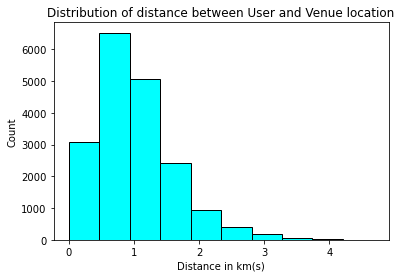

In [30]:
plt.hist(data["dist_user_venue"], color="aqua", edgecolor='black')
plt.title("Distribution of distance between User and Venue location")
plt.xlabel("Distance in km(s)")
plt.ylabel("Count")

## Exploration: Conclusion ✨
#### 1. Sat, Sun getting more orders comparision to weekdays.
#### 2. Getting more orders at 7 to 9 hours [breakfasttime] and 14 to 16 hours [lunchtime]
#### 3. 43% of orders are getting delayed max by 34 mins and max orders are delayed by 5 to 10 mins and 57% of on or before time.
#### 4. Distance between User and Venue location is between [0, 4]. Majorly is in [0.5, 1.5]

In [31]:
# G = ox.graph_from_place('Piedmont, CA, USA', network_type='drive')
# G = graph_from_bbox(60.164, 60.168, 24.925, 24.935, network_type='drive')
# G = ox.add_edge_speeds(G)
# G = ox.add_edge_travel_times(G)
# osmnx.distance.k_shortest_paths(G, orig, dest, k, weight='length')
# fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')


In [32]:
# import networkx as nx
# ox.config(use_cache=True, log_console=True)

# coords_1 = (60.174, 24.923)
# coords_2 = (60.181, 24.926 )

# G = ox.graph_from_bbox(60.174, 24.923, 60.181, 24.926, network_type='drive')
# node_id = list(G.nodes)

# print(node_id)

# # G = ox.speed.add_edge_speeds(G)
# # G = ox.speed.add_edge_travel_times(G)

# orig = ox.get_nearest_node(G, (-33.889606, 151.283306))
# dest = ox.get_nearest_node(G, (-33.889927, 151.280497))
# route = nx.shortest_path(G, orig, dest, 'travel_time')

# ox.plot_route_folium(G, route)

In [33]:
## How many times estimation is failing based on weather.
## How many items were sold in a week.
## krishnayak

## Modelling : Forecasting No. of orders for next hour.
#### Wooho!! Lets Predict how many orders we could get in next hour..

In [34]:
data

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,time,date,hour,weekday,dist_user_venue
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,2020-08-01 06:07:00,2020-08-01,6,5,0.222830
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,2020-08-01 06:17:00,2020-08-01,6,5,1.460344
2,2020-08-01 06:54:00.000,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0,2020-08-01 06:54:00,2020-08-01,6,5,0.157311
3,2020-08-01 07:09:00.000,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0,2020-08-01 07:09:00,2020-08-01,7,5,2.449984
4,2020-08-01 07:10:00.000,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0,2020-08-01 07:10:00,2020-08-01,7,5,0.556318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18701,2020-09-30 19:27:00.000,-1,1,60.170,24.946,60.170,24.945,24,23,0.0,12.8,2.34419,0.0,2020-09-30 19:27:00,2020-09-30,19,2,0.055513
18702,2020-09-30 19:36:00.000,-8,6,60.185,24.944,60.178,24.949,23,15,0.0,12.8,2.34419,0.0,2020-09-30 19:36:00,2020-09-30,19,2,0.827796
18703,2020-09-30 19:39:00.000,-14,3,60.186,24.949,60.188,24.956,25,11,0.0,12.8,2.34419,0.0,2020-09-30 19:39:00,2020-09-30,19,2,0.447776
18704,2020-09-30 19:42:00.000,-11,3,60.172,24.929,60.168,24.930,21,10,0.0,12.8,2.34419,0.0,2020-09-30 19:42:00,2020-09-30,19,2,0.449105


### Univariate time series modelling

In [35]:
df1 = data[["date","hour"]]


In [37]:
df1["no_of_orders"] = 1

C:\Users\This PC\AppData\Local\Temp\ipykernel_19472\1203673736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["no_of_orders"] = 1


In [38]:
if ((df1["date"]==datetime.date(2020, 8, 1)) & (df1["hour"]==4)).any():
    print("Yes")
else:
    print("NO")

list_dates = df1.date.unique()
df1 = utility.fill_all_hour_data(df1, list_dates)

NO


In [39]:

    
# print(df1.date.unique())

# list_dates = df1.date.unique()

# for dat_ in list_dates:
#     for time in ["4","5", "6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22"]:
#         if ( (df1["date"]==dat_) & (df1["hour"]==int(time)) ).any()==False:
#             df1 = df1.append({"date":dat_,"hour":int(time),"no_of_orders":0}, ignore_index=True)
     

In [40]:
df1 = df1.sort_values(by=["date"])

In [41]:
df1

,date,hour,no_of_orders
0,2020-08-01,6,1
205,2020-08-01,16,1
204,2020-08-01,16,1
203,2020-08-01,16,1
202,2020-08-01,16,1
...,...,...,...
18550,2020-09-30,14,1
18551,2020-09-30,14,1
18552,2020-09-30,14,1
18546,2020-09-30,14,1


In [42]:
df1 = df1.set_index('date')
print("Dates which are missing", pd.date_range(
  start="2020-08-01", end="2020-09-30").difference(df1.index))
df1 = df1.reset_index()

Dates which are missing DatetimeIndex([], dtype='datetime64[ns]', freq=None)


#### No date is missing in data

In [43]:
df1.groupby(["date", "hour"]).sum()

no_of_orders
date       hour              
2020-08-01 4                0
           5                0
           6                3
           7                6
           8               15
...                       ...
2020-09-30 18              19
           19               8
           20               1
           21               0
           22               0

[1159 rows x 1 columns]

In [103]:
df_hourly_orders = df1.groupby(["date", "hour"]).sum().reset_index()["no_of_orders"]

In [104]:
df_hourly_orders

0        0
1        0
2        3
3        6
4       15
        ..
1154    19
1155     8
1156     1
1157     0
1158     0
Name: no_of_orders, Length: 1159, dtype: int64

Text(0.5, 1.0, 'All orders plot grouped by date and hour')

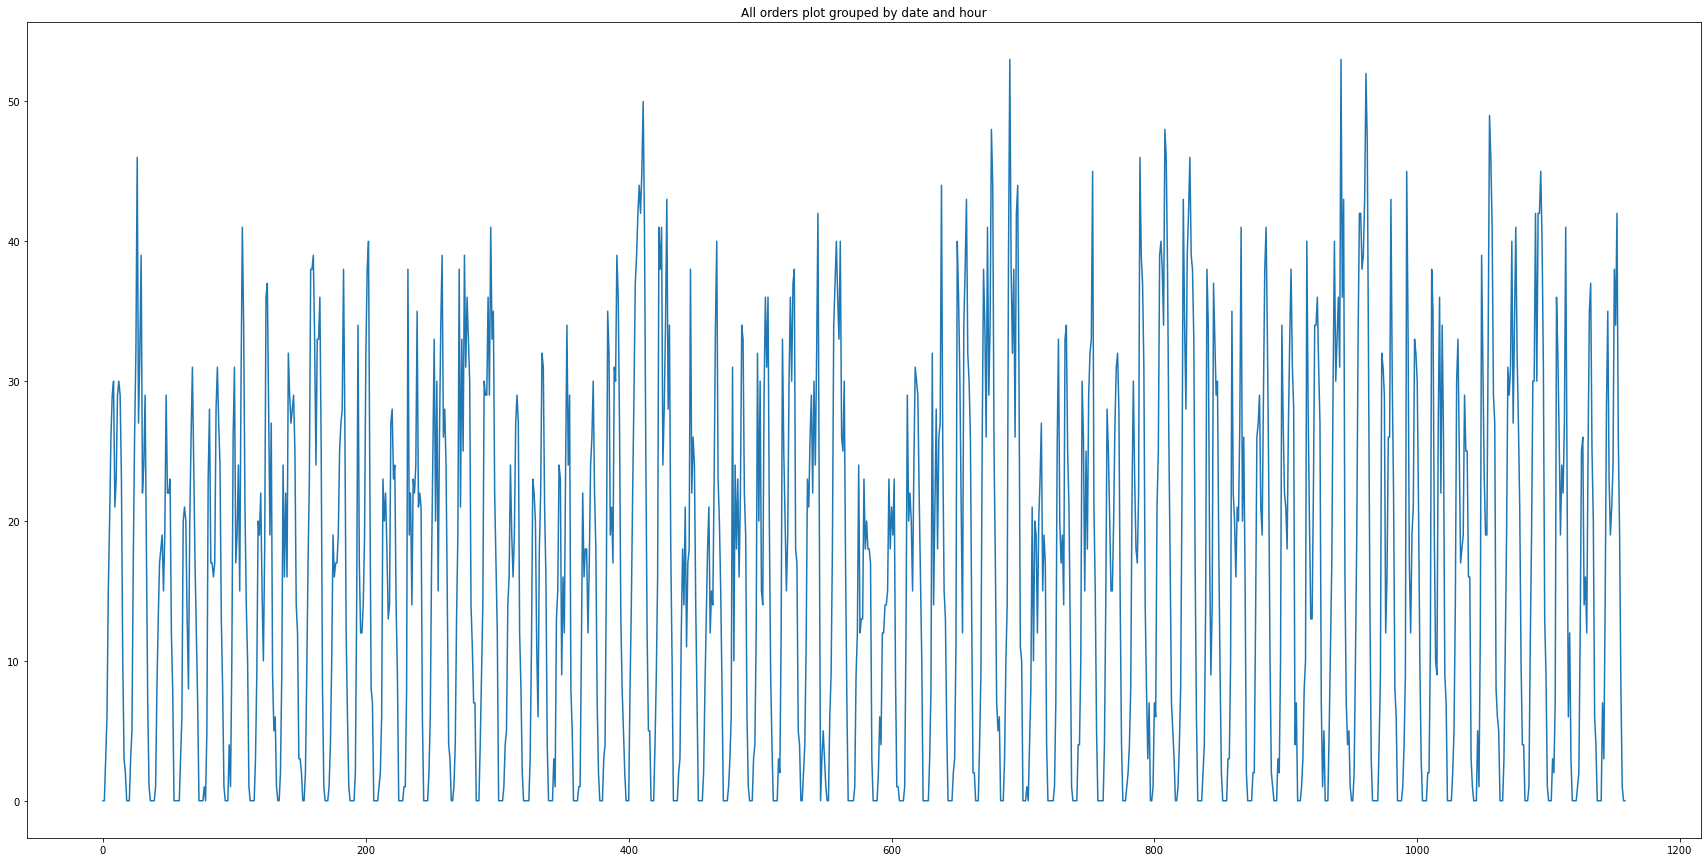

In [105]:
plt.figure(figsize=(30,15))
plt.plot(df_hourly_orders)
plt.title("All orders plot grouped by date and hour")

#### As we can see from above plot that pattern is kind of repeating for a day, it is slowly increasing then there is a very small downfall and then increase..again then decrease which repeats from day to day!!

### Model Designing

In [106]:
## Standardizing the data

scaler=MinMaxScaler(feature_range=(0,1))
df_hourly_orders=scaler.fit_transform(np.array(df_hourly_orders).reshape(-1,1))

In [107]:
df_hourly_orders

array([[0.        ],
       [0.        ],
       [0.05660377],
       ...,
       [0.01886792],
       [0.        ],
       [0.        ]])

In [108]:
##splitting dataset into train and test split
# training_size=int(len(df_hourly_orders)*0.65)
# test_size=len(df_hourly_orders)-training_size
# train_data,test_data=df_hourly_orders[0:training_size,:],df_hourly_orders[training_size:len(df_hourly_orders),:1]
train_data, training_size, test_data, test_size = utility.train_test_split_(df_hourly_orders,0.65)


In [109]:
training_size,test_size

(753, 406)

In [110]:
train_data

array([[0.        ],
       [0.        ],
       [0.05660377],
       [0.11320755],
       [0.28301887],
       [0.37735849],
       [0.49056604],
       [0.54716981],
       [0.56603774],
       [0.39622642],
       [0.43396226],
       [0.54716981],
       [0.56603774],
       [0.54716981],
       [0.43396226],
       [0.18867925],
       [0.05660377],
       [0.03773585],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.05660377],
       [0.09433962],
       [0.32075472],
       [0.49056604],
       [0.60377358],
       [0.86792453],
       [0.50943396],
       [0.60377358],
       [0.73584906],
       [0.41509434],
       [0.45283019],
       [0.54716981],
       [0.33962264],
       [0.13207547],
       [0.01886792],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.01886792],
       [0.1509434 ],
       [0.24528302],
       [0.32075472],
       [0.33962264],
       [0.35849057],
       [0.28301887],
       [0.358

In [111]:
# convert an array of values into a dataset matrix
## setting timestep by defualt=1
# def dataset_creation(dataset, time_step=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-time_step-1):
# 		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
# 		dataX.append(a)
# 		dataY.append(dataset[i + time_step, 0])
# 	return np.array(dataX), np.array(dataY)



In [112]:
time_step = 10
X_train, y_train = utility.dataset_creation(train_data, time_step)
X_test, ytest = utility.dataset_creation(test_data, time_step)

In [113]:
print(X_train.shape), print(y_train.shape)

(742, 10)
(742,)


(None, None)

In [114]:
## Reshaping the data so that it can be inputted into the DL model

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [115]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [116]:
hist =  model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)
# with open('history.json', 'w') as f:
#     json.dump(hist.history, f)

utility.save_json('history.json', hist.history)

Epoch 1/100
12/12 [==============================] - 21s 417ms/step - loss: 0.0975 - val_loss: 0.0972
Epoch 2/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0679 - val_loss: 0.0851
Epoch 3/100
12/12 [==============================] - 1s 77ms/step - loss: 0.0579 - val_loss: 0.0663
Epoch 4/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0456 - val_loss: 0.0470
Epoch 5/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0380 - val_loss: 0.0452
Epoch 6/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0338 - val_loss: 0.0412
Epoch 7/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0315 - val_loss: 0.0394
Epoch 8/100
12/12 [==============================] - 1s 63ms/step - loss: 0.0309 - val_loss: 0.0417
Epoch 9/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0301 - val_loss: 0.0364
Epoch 10/100
12/12 [==============================] - 1s 63ms/step - loss: 0.0297 - val_loss: 0.03

In [117]:
model.save("models/LSTMN_UNIVARIATE.h5")

[0.09723690152168274, 0.08511417359113693, 0.06626606732606888, 0.04700290039181709, 0.045237842947244644, 0.041243523359298706, 0.039417486637830734, 0.041654158383607864, 0.036394644528627396, 0.03989410400390625, 0.0360102578997612, 0.03564707562327385, 0.0362938717007637, 0.04193594306707382, 0.03513014689087868, 0.03397868573665619, 0.03783675655722618, 0.0338338166475296, 0.03301326185464859, 0.03616846725344658, 0.033981744199991226, 0.038425251841545105, 0.03584185242652893, 0.04299647733569145, 0.03072882629930973, 0.030054939910769463, 0.029028484597802162, 0.027684567496180534, 0.024823835119605064, 0.023144332692027092, 0.023948419839143753, 0.020496664568781853, 0.02106570452451706, 0.024978823959827423, 0.019839130342006683, 0.020604753866791725, 0.02153593674302101, 0.01932835765182972, 0.02053881622850895, 0.0169315654784441, 0.014476141892373562, 0.016553306952118874, 0.016041899099946022, 0.01449147704988718, 0.012990372255444527, 0.013188195414841175, 0.0137887354940

Text(0.5, 1.0, 'Loss Curve of Univariate Time Series Model')

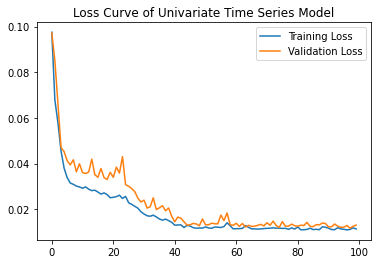

In [118]:
with open('history.json', 'r') as f:
    hist_ = f.readlines()
print(ast.literal_eval(hist_[0])["val_loss"])
plt.plot(ast.literal_eval(hist_[0])["loss"])
plt.plot(ast.literal_eval(hist_[0])["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Loss Curve of Univariate Time Series Model")

In [137]:
# model  = tf.keras.models.load_model('LSTMN_UNIVARIATE.h5')

In [119]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [120]:

## Seeing the predictiion and actual output
print(test_predict)
print(scaler.inverse_transform(ytest.reshape(-1,1)))

[[ 8.3586454e+00]
 [ 2.2787796e+01]
 [ 2.6810589e+01]
 [ 1.9735229e+01]
 [ 1.6998819e+01]
 [ 1.8160076e+01]
 [ 2.1624350e+01]
 [ 2.6927464e+01]
 [ 2.9062128e+01]
 [ 2.5726206e+01]
 [ 2.1259207e+01]
 [ 1.6677095e+01]
 [ 8.8562765e+00]
 [ 1.9606616e+00]
 [-1.4591497e+00]
 [-1.6664438e+00]
 [-9.4359577e-01]
 [ 8.5606676e-01]
 [ 3.6534374e+00]
 [ 9.4237680e+00]
 [ 1.8898464e+01]
 [ 2.3445364e+01]
 [ 1.9000179e+01]
 [ 1.8000498e+01]
 [ 1.9663525e+01]
 [ 2.2689541e+01]
 [ 2.7687393e+01]
 [ 3.9683270e+01]
 [ 3.4919594e+01]
 [ 3.1101116e+01]
 [ 2.2865028e+01]
 [ 1.0083813e+01]
 [ 5.3142014e+00]
 [ 8.1946933e-01]
 [ 2.6717510e+00]
 [-4.4348556e-01]
 [ 1.7143680e-01]
 [ 1.0831615e+00]
 [ 6.6990829e+00]
 [ 1.4055462e+01]
 [ 2.5521477e+01]
 [ 2.5700817e+01]
 [ 2.8772713e+01]
 [ 3.3958652e+01]
 [ 3.4008770e+01]
 [ 3.5414627e+01]
 [ 4.2869709e+01]
 [ 4.2872700e+01]
 [ 3.8056931e+01]
 [ 2.2258093e+01]
 [ 1.0771614e+01]
 [ 2.6845598e+00]
 [ 1.8401275e+00]
 [ 9.1551912e-01]
 [-1.3469037e-01]
 [ 2.88487

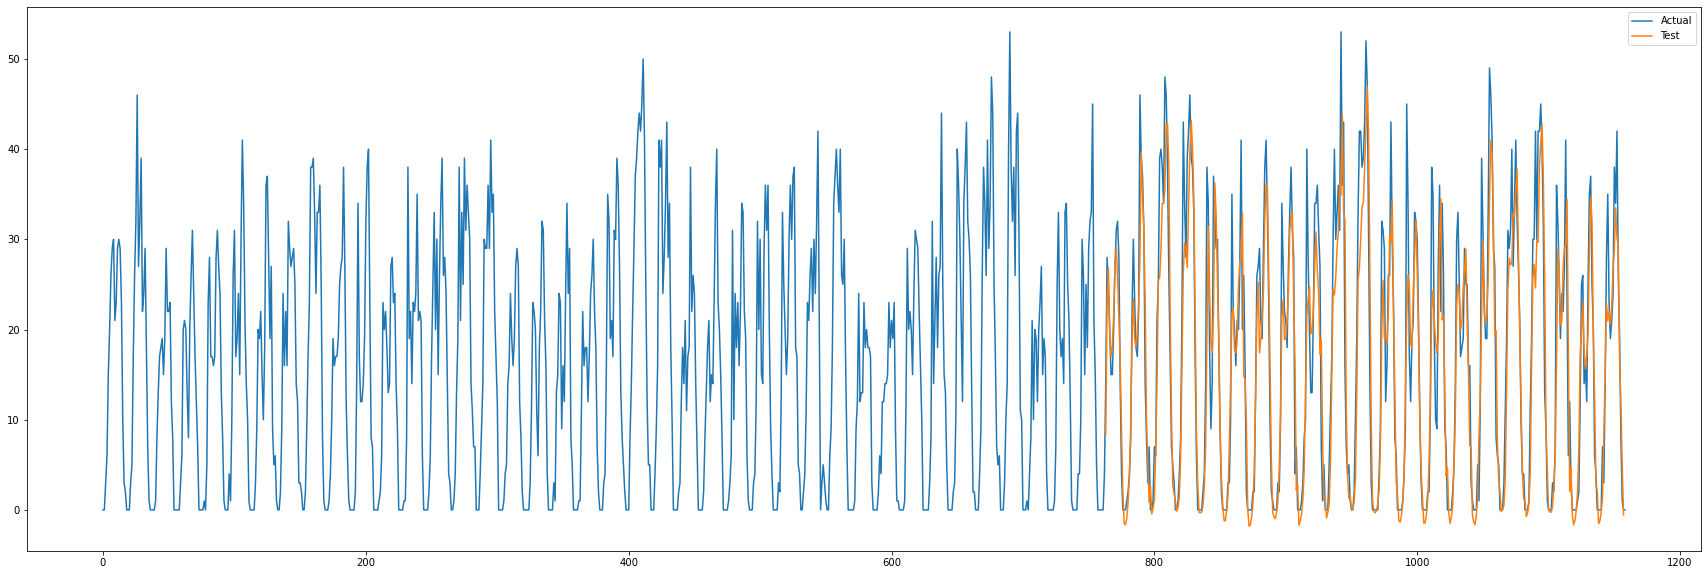

In [121]:
### Plotting 
# shift train predictions for plotting
plt.figure(figsize=(30,10))
look_back=10
trainPredictPlot = np.empty_like(df_hourly_orders)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_hourly_orders)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_hourly_orders)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_hourly_orders))
plt.plot(testPredictPlot)
plt.legend(["Actual","Test"])
plt.show()

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


## EVALUATION: RSME
#### For evaluation metrics, I have choosen RSME because we are predicting continous variables and it will help us in understanding how we are deviating from our actual results.
#### RSME is prone to outliers as it will boom for large errors but as far as we can understand from the data we are not having very much outliers.

In [122]:
### Test Data RMSE

math.sqrt(mean_squared_error(ytest,test_predict))

20.22554625364723

In [123]:
math.sqrt(mean_squared_error(y_train,train_predict))

18.80820540976867

## Multivariate Analysis

In [36]:
df2 = data[["date","hour","CLOUD_COVERAGE","TEMPERATURE","WIND_SPEED","PRECIPITATION"]]
df2["no_of_orders"] = 1

C:\Users\This PC\AppData\Local\Temp\ipykernel_7684\656156839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["no_of_orders"] = 1


In [37]:
print(df2.date.unique())

list_dates = df2.date.unique()

df2 = utility.fill_all_hour_data(df2, list_dates,ismultivariate=True)

# for dat_ in list_dates:
#     for time in ["4","5", "6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22"]:
#         if ( (df2["date"]==dat_) & (df2["hour"]==int(time)) ).any()==False:
#             print({"date":dat_,"hour":time,"no_of_orders":0})
#             df2 = df2.append({"date":dat_,"hour":int(time),"no_of_orders":0,"CLOUD_COVERAGE":0,"TEMPERATURE":0,"WIND_SPEED":0,"PRECIPITATION":0}, ignore_index=True)

[datetime.date(2020, 8, 1) datetime.date(2020, 8, 2)
 datetime.date(2020, 8, 3) datetime.date(2020, 8, 4)
 datetime.date(2020, 8, 5) datetime.date(2020, 8, 6)
 datetime.date(2020, 8, 7) datetime.date(2020, 8, 8)
 datetime.date(2020, 8, 9) datetime.date(2020, 8, 10)
 datetime.date(2020, 8, 11) datetime.date(2020, 8, 12)
 datetime.date(2020, 8, 13) datetime.date(2020, 8, 14)
 datetime.date(2020, 8, 15) datetime.date(2020, 8, 16)
 datetime.date(2020, 8, 17) datetime.date(2020, 8, 18)
 datetime.date(2020, 8, 19) datetime.date(2020, 8, 20)
 datetime.date(2020, 8, 21) datetime.date(2020, 8, 22)
 datetime.date(2020, 8, 23) datetime.date(2020, 8, 24)
 datetime.date(2020, 8, 25) datetime.date(2020, 8, 26)
 datetime.date(2020, 8, 27) datetime.date(2020, 8, 28)
 datetime.date(2020, 8, 29) datetime.date(2020, 8, 30)
 datetime.date(2020, 8, 31) datetime.date(2020, 9, 1)
 datetime.date(2020, 9, 2) datetime.date(2020, 9, 3)
 datetime.date(2020, 9, 4) datetime.date(2020, 9, 5)
 datetime.date(2020, 9, 

In [38]:
df2

,date,hour,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,no_of_orders
0,2020-08-01,6,0.0,15.0,3.53644,0.0,1
1,2020-08-01,6,0.0,15.0,3.53644,0.0,1
2,2020-08-01,6,0.0,15.0,3.53644,0.0,1
3,2020-08-01,7,0.0,16.7,3.52267,0.0,1
4,2020-08-01,7,0.0,16.7,3.52267,0.0,1
...,...,...,...,...,...,...,...
0,2020-09-29,21,0.0,0.0,0.00000,0.0,0
0,2020-09-29,22,0.0,0.0,0.00000,0.0,0
0,2020-09-30,4,0.0,0.0,0.00000,0.0,0
0,2020-09-30,21,0.0,0.0,0.00000,0.0,0


In [39]:
# df2 = df2.drop(columns=["TIMESTAMP"])

In [40]:
multivariate_data = df2.groupby(["date","hour"]).aggregate({"no_of_orders":np.sum,"CLOUD_COVERAGE":np.mean,"TEMPERATURE":np.mean,"WIND_SPEED":np.mean,"PRECIPITATION":np.mean})

In [41]:
multivariate_data

no_of_orders  CLOUD_COVERAGE  TEMPERATURE  WIND_SPEED  \
date       hour                                                          
2020-08-01 4                0             0.0          0.0     0.00000   
           5                0             0.0          0.0     0.00000   
           6                3             0.0         15.0     3.53644   
           7                6             0.0         16.7     3.52267   
           8               15            25.0         17.8     3.35088   
...                       ...             ...          ...         ...   
2020-09-30 18              19            45.0         12.8     2.24368   
           19               8             0.0         12.8     2.34419   
           20               1             0.0         12.8     2.34249   
           21               0             0.0          0.0     0.00000   
           22               0             0.0          0.0     0.00000   

                 PRECIPITATION  
date       hour                 
2020-08-01 4               0.0  
           5               0.0  
           6               0.0  
           7               0.0  
           8               0.0  
...                        ...  
2020-09-30 18              0.0  
           19              0.0  
           20              0.0  
           21              0.0  
           22              0.0  

[1159 rows x 5 columns]

In [42]:
multivariate_data = multivariate_data.reset_index().drop(columns=["date","hour"])
multivariate_data

,no_of_orders,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
0,0,0.0,0.0,0.00000,0.0
1,0,0.0,0.0,0.00000,0.0
2,3,0.0,15.0,3.53644,0.0
3,6,0.0,16.7,3.52267,0.0
4,15,25.0,17.8,3.35088,0.0
...,...,...,...,...,...
1154,19,45.0,12.8,2.24368,0.0
1155,8,0.0,12.8,2.34419,0.0
1156,1,0.0,12.8,2.34249,0.0
1157,0,0.0,0.0,0.00000,0.0


In [43]:
multivariate_data.isna().sum()

no_of_orders       0
CLOUD_COVERAGE    14
TEMPERATURE       14
WIND_SPEED        14
PRECIPITATION      0
dtype: int64

In [44]:
## handling null values for waether data
multivariate_data["CLOUD_COVERAGE"].fillna(np.mean(multivariate_data["CLOUD_COVERAGE"]), inplace=True)
multivariate_data["TEMPERATURE"].fillna(np.mean(multivariate_data["TEMPERATURE"]), inplace=True)
multivariate_data["WIND_SPEED"].fillna(np.mean(multivariate_data["WIND_SPEED"]), inplace=True)

In [45]:
# scaler1=MinMaxScaler(feature_range=(0,1))
# grouped_data=scaler1.fit_transform(np.array(grouped_data).reshape(-1,1))

In [46]:
multivariate_data.shape

(1159, 5)

In [47]:
## Scaling transformation
scalers={}
for i in multivariate_data.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(multivariate_data[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    multivariate_data[i]=s_s

In [48]:
multivariate_data

,no_of_orders,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
0,-1.000000,-1.0,-1.000000,-1.000000,-1.0
1,-1.000000,-1.0,-1.000000,-1.000000,-1.0
2,-0.886792,-1.0,0.123596,-0.282473,-1.0
3,-0.773585,-1.0,0.250936,-0.285267,-1.0
4,-0.433962,-0.5,0.333333,-0.320122,-1.0
...,...,...,...,...,...
1154,-0.283019,-0.1,-0.041199,-0.544768,-1.0
1155,-0.698113,-1.0,-0.041199,-0.524375,-1.0
1156,-0.962264,-1.0,-0.041199,-0.524720,-1.0
1157,-1.000000,-1.0,-1.000000,-1.000000,-1.0


In [49]:
multivariate_data = np.array(multivariate_data)

In [54]:
multivariate_data.shape

(1159, 5)

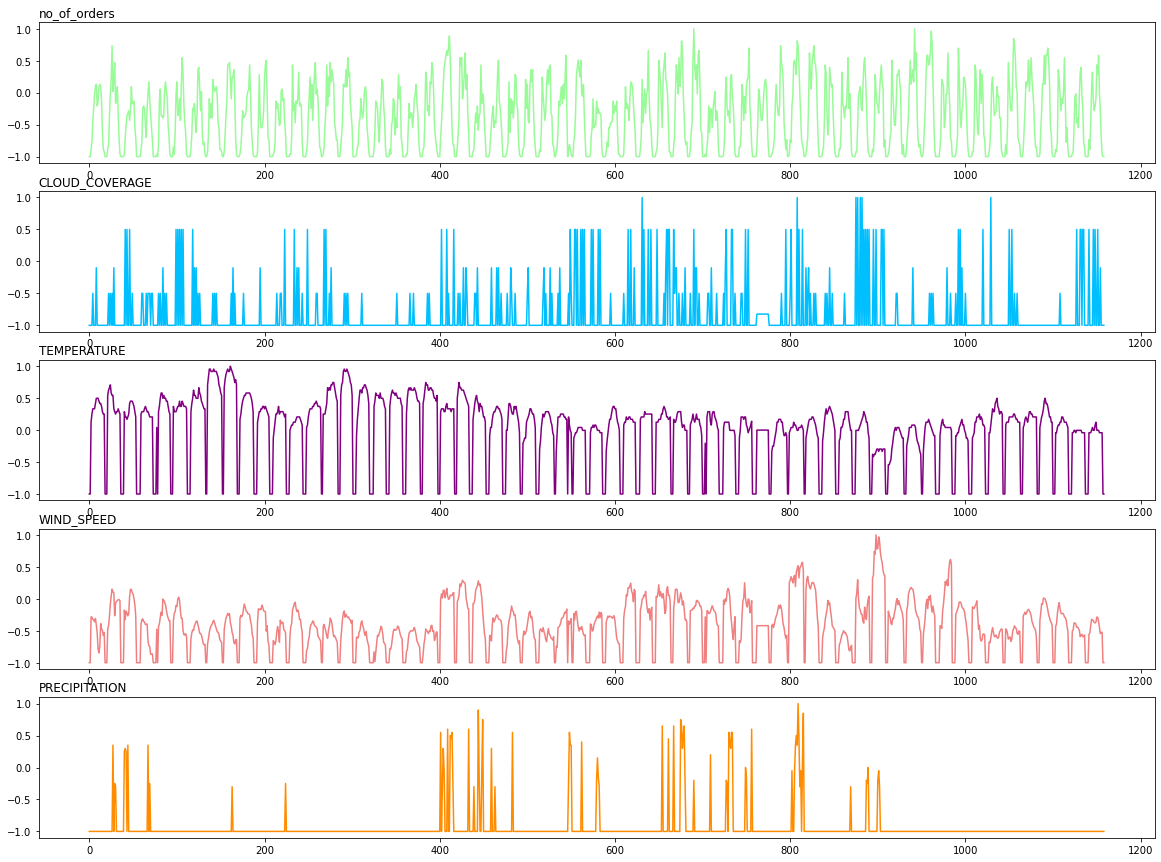

In [60]:
groups = [0,1,2,3,4]
columns = ["no_of_orders", "CLOUD_COVERAGE", "TEMPERATURE", "WIND_SPEED", "PRECIPITATION"]
color = ['palegreen', 'deepskyblue', 'purple', 'lightcoral', 'darkorange']

i=1
plt.figure(figsize=(20,15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(multivariate_data[:, group], color=color[group])
    plt.title(columns[group], loc='left')
    i = i +1

plt.show()

In [71]:
##splitting dataset into train and test split
# training_size=int(len(grouped_data)*0.65)
# test_size=len(grouped_data)-training_size
# train_data,test_data=grouped_data[0:training_size,:],grouped_data[training_size:len(grouped_data),:]

train_data, training_size, test_data, test_size = utility.train_test_split_multivariate(multivariate_data,0.65)

In [72]:
train_data.shape

(753, 5)

In [73]:
# def dataset_creation(dataset, time_step=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-time_step-1):
# 		a = dataset[i:(i+time_step), :]   ###i=0, 0,1,2,3-----99   100 
# 		dataX.append(a)
# 		dataY.append(dataset[i + time_step, 0])
# 	return np.array(dataX), np.array(dataY)

In [74]:
time_step = 10
X_train, y_train = utility.dataset_creation(train_data, time_step, ismultivariate=True)
X_test, ytest = utility.dataset_creation(test_data, time_step, ismultivariate=True)

In [75]:
X_train.shape
# X_test.shape
# ytest.shape
# y_train.shape

(742, 10, 5)

In [76]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error',optimizer=opt)

In [77]:
hist =  model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=128,verbose=1)
# with open('history_multivariate.json', 'w') as f:
#     json.dump(hist.history, f)

utility.save_json('history_multivariate.json',hist.history)

Epoch 1/100
6/6 [==============================] - 21s 877ms/step - loss: 0.4028 - val_loss: 0.4026
Epoch 2/100
6/6 [==============================] - 0s 86ms/step - loss: 0.3694 - val_loss: 0.3800
Epoch 3/100
6/6 [==============================] - 1s 90ms/step - loss: 0.3394 - val_loss: 0.3608
Epoch 4/100
6/6 [==============================] - 1s 94ms/step - loss: 0.3145 - val_loss: 0.3446
Epoch 5/100
6/6 [==============================] - 1s 90ms/step - loss: 0.2918 - val_loss: 0.3320
Epoch 6/100
6/6 [==============================] - 1s 91ms/step - loss: 0.2729 - val_loss: 0.3231
Epoch 7/100
6/6 [==============================] - 1s 92ms/step - loss: 0.2580 - val_loss: 0.3176
Epoch 8/100
6/6 [==============================] - 1s 97ms/step - loss: 0.2474 - val_loss: 0.3147
Epoch 9/100
6/6 [==============================] - 0s 87ms/step - loss: 0.2407 - val_loss: 0.3131
Epoch 10/100
6/6 [==============================] - 1s 89ms/step - loss: 0.2352 - val_loss: 0.3099
Epoch 11/100
6/6 

## Evaluation

[0.40263813734054565, 0.37996819615364075, 0.3608175814151764, 0.34464168548583984, 0.33203256130218506, 0.3230801224708557, 0.31760528683662415, 0.3147200047969818, 0.31311747431755066, 0.3099224865436554, 0.30544278025627136, 0.29946112632751465, 0.2935729920864105, 0.2871644198894501, 0.2813063859939575, 0.2756361961364746, 0.26942214369773865, 0.2636640965938568, 0.25779420137405396, 0.25177767872810364, 0.24545815587043762, 0.23915328085422516, 0.23229186236858368, 0.2267053723335266, 0.2226291000843048, 0.2173994779586792, 0.21327757835388184, 0.20983996987342834, 0.20519554615020752, 0.20221354067325592, 0.20033544301986694, 0.1967318058013916, 0.19619576632976532, 0.19547709822654724, 0.19318553805351257, 0.193038672208786, 0.19128257036209106, 0.19448436796665192, 0.1950545459985733, 0.19120186567306519, 0.1918608844280243, 0.19753065705299377, 0.18703553080558777, 0.19171161949634552, 0.19498613476753235, 0.18818268179893494, 0.19156567752361298, 0.19092606008052826, 0.190437

Text(0.5, 1.0, 'Loss Curve of Multivariate Time Series Model')

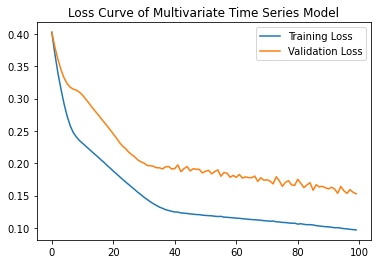

In [78]:

with open('history_multivariate.json', 'r') as f:
    hist_ = f.readlines()
print(ast.literal_eval(hist_[0])["val_loss"])
plt.plot(ast.literal_eval(hist_[0])["loss"])
plt.plot(ast.literal_eval(hist_[0])["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Loss Curve of Multivariate Time Series Model")

In [98]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transformback to original form
train_predict=scalers['scaler_no_of_orders'].inverse_transform(train_predict)
test_predict=scalers['scaler_no_of_orders'].inverse_transform(test_predict)

In [94]:
multivariate_data[:,0]

array([-1.        , -1.        , -0.88679245, ..., -0.96226415,
       -1.        , -1.        ])

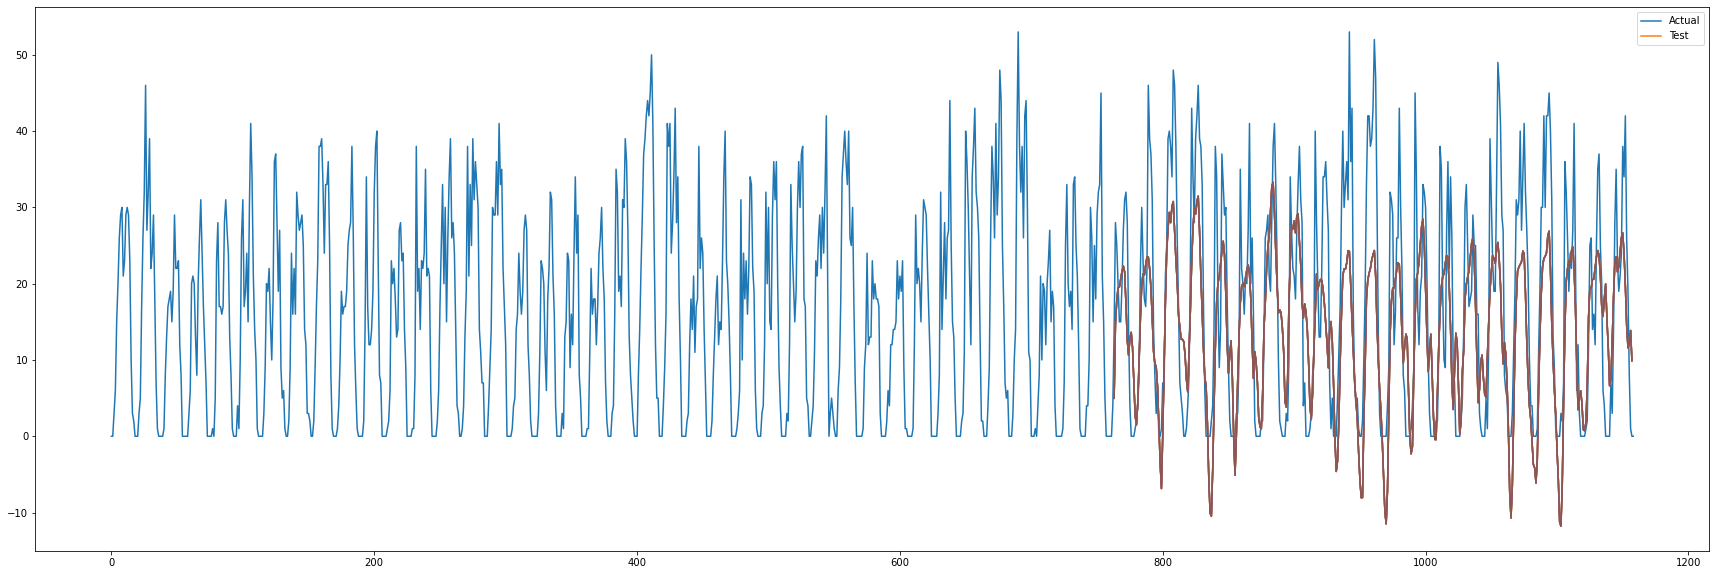

In [99]:
plt.figure(figsize=(30,10))
look_back=10
trainPredictPlot = np.empty_like(multivariate_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(multivariate_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(multivariate_data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scalers['scaler_no_of_orders'].inverse_transform(multivariate_data[:,0].reshape(-1,1)))
plt.plot(testPredictPlot)
plt.legend(["Actual","Test"])
plt.show()



In [100]:
math.sqrt(mean_squared_error(ytest,test_predict))


17.081149676035153